# Ingest Content

## Dependencies

Install the following dependencies first:

In [ ]:
!pip install bs4 jsonlines

## Find all internal URLs

First step is to crawl a domain for all internal links leading to HTML content. Do this until everything is discovered. Enter your domain through adjusting the `url` in `__main__`.

Write the set of discovered URLs from `all_links` to disk, converting them to `jsonl` format for easier processing in the next steps. We'll build upon that `page` dict in the following steps.

In [52]:
import requests
import jsonlines
from urllib.parse import urlparse, urljoin
from bs4 import BeautifulSoup
 
def get_domain(url):
    parsed_uri = urlparse(url)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain
 
def get_links(url, response):
    if (response.ok): 
        soup = BeautifulSoup(response.text, 'html.parser')
        links = set()
        for link in soup.find_all('a'):
            link_url = link.get('href')
            if link_url:
                absolute_link = urljoin(url, link_url)
                if absolute_link.startswith(domain):
                    links.add(absolute_link)
        return links
    return [] 

def mapLink(url):
    page = dict()
    page['url'] = url
    return page 
 
if __name__ == '__main__':
    url = 'https://www.kickstartDS.com'
    domain = get_domain(url)
    queue = [url]
    visited = set()
    all_links = set()
 
    while queue:
        url = queue.pop(0)
        visited.add(url)
        response = requests.get(url)
        if (response.ok and "text/html" in response.headers['Content-Type']):
            print(url)
            if (url.rstrip("/") not in all_links):
                all_links.add(url.rstrip("/"))
    
            links = get_links(url, response)
            for link in links:
                if link not in visited and link not in queue and '#' not in link and '?' not in link:
                    queue.append(link)
        
    print('All done! ' + str(len(all_links)) + ' links discovered.')

    pages = map(mapLink, all_links)

    with jsonlines.open('pages.jsonl', 'w') as writer:
        writer.write_all(pages)

https://www.kickstartDS.com
https://www.kickstartDS.com/blog/
https://www.kickstartDS.com/storybook/
https://www.kickstartDS.com/docs/
https://www.kickstartDS.com/about/
https://www.kickstartDS.com/storybook
https://www.kickstartDS.com/services/
https://www.kickstartDS.com/
https://www.kickstartDS.com/cookies/
https://www.kickstartDS.com/integrations/
https://www.kickstartDS.com/privacy/
https://www.kickstartDS.com/blog/great-components/
https://www.kickstartDS.com/legal/
https://www.kickstartDS.com/blog/setting-up-a-working-design-system-in-less-than-a-day/
https://www.kickstartDS.com/blog/unlocking-the-frontend-pt1/
https://www.kickstartDS.com/blog/quarterly-design-system-and-frontend-podcast-roundup-q1-22/
https://www.kickstartDS.com/blog/everything-meta-and-everything-matters/
https://www.kickstartDS.com/blog/kickstartds-is-open-source-now-lets-start-to-democratize-design-systems-today/
https://www.kickstartDS.com/blog/why-we-created-kickstartds/
https://www.kickstartDS.com/blog/ho

## More dependencies

Install trafilatura, that will be used to extract the content from pages, and tiktoken to have a first relevant token measurement for complete page content.

In [ ]:
!pip install trafilatura tiktoken

## Extract content from discovered pages

We'll keep Markdown formatting for now. It will be used to split sections from pages by slicing by headlines. 

In [53]:
import re
import jsonlines
import tiktoken
from bs4 import BeautifulSoup
from trafilatura import fetch_url, extract
from markdown import markdown

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

extracted_content = []
with jsonlines.open('pages.jsonl') as pages:
    for page in pages:
        downloaded = fetch_url(page['url'])
        parsed = BeautifulSoup(downloaded)
        ogTitle = parsed.find("meta", property="og:title")
        title = parsed.title.string if parsed.title.string else ogTitle["content"] if ogTitle else page['url']
        result = extract(downloaded, url=page['url'], include_formatting=True)

        if result is None:
            print('couldnt extract:', page['url'])
        else:
            augmented = dict()
            augmented['url'] = page['url']
            
            augmented['content'] = dict()
            augmented['content']['raw'] = markdown_to_text(result)
            augmented['content']['markdown'] = result
            augmented['lines'] = result.splitlines()
            augmented['title'] = title
            augmented['size'] = len(result)
            augmented['token'] = len(enc.encode(result))
            extracted_content.append(augmented)
            print('extracted:', augmented['url'], augmented['title'], str(augmented['token']) + ' Token,', len(result))  

with jsonlines.open('pages_extracted.jsonl', 'w') as pages:
    pages.write_all(extracted_content)
    
print('wrote extracted content to "pages_extracted.jsonl"')

extracted: https://www.kickstartDS.com/integrations Integrations - making your interface come alive! 1419 Token, 6527
extracted: https://www.kickstartDS.com/docs/guides/create/storybook 3. Configure Storybook | kickstartDS docs 8856 Token, 32196
extracted: https://www.kickstartDS.com/docs/guides/examples/components/section Extend `Section` component | kickstartDS docs 5739 Token, 21013
extracted: https://www.kickstartDS.com/docs/guides/create/design 2. Design Application | kickstartDS docs 4565 Token, 16927
extracted: https://www.kickstartDS.com/docs/guides/components/adapt Adapt a component | kickstartDS docs 3149 Token, 14045
extracted: https://www.kickstartDS.com/docs/intro Introduction to kickstartDS | kickstartDS docs 2093 Token, 9915
extracted: https://www.kickstartDS.com/blog/everything-meta-and-everything-matters Everything Meta! And everything matters. 1013 Token, 4932
extracted: https://www.kickstartDS.com/docs/foundations/layout/sections Sections | kickstartDS docs 2000 Toke

extracted: https://www.kickstartDS.com/docs/foundations/token Token | kickstartDS docs 193 Token, 957
extracted: https://www.kickstartDS.com/docs/guides/examples/components/interstitial Create `Interstitial` component | kickstartDS docs 3398 Token, 14102
extracted: https://www.kickstartDS.com/docs/concepts Concepts | kickstartDS docs 32 Token, 126
extracted: https://www.kickstartDS.com/docs/guides/create/start 1. Start your Design System | kickstartDS docs 1514 Token, 5827
extracted: https://www.kickstartDS.com/blog/release-spotlight-semantic-token Release Spotlight: Semantic Token 1915 Token, 8975
extracted: https://www.kickstartDS.com/docs/foundations/components/component-api Component API | kickstartDS docs 125 Token, 619
extracted: https://www.kickstartDS.com/docs/integration/frameworks/nextjs Next.js | kickstartDS docs 637 Token, 2522
extracted: https://www.kickstartDS.com/blog/great-components Great components inside kickstartDS 1222 Token, 5721
extracted: https://www.kickstartDS

## Even more dependencies

Install the BERT extractive summarizer and Sentence Transformers, we'll use these to create summaries as a first step.

In [ ]:
!pip install bert-extractive-summarizer sentence-transformers

## Create SBert summaries

We first create SBert summaries by identifying the most central sentences on a page, concatenating those for a rough first summary.

In [54]:
import tiktoken
from summarizer.sbert import SBertSummarizer

enc = tiktoken.encoding_for_model("text-davinci-003")
model = SBertSummarizer('paraphrase-multilingual-MiniLM-L12-v2')  

extracted_content = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        result = model(page['content']['raw'], num_sentences=5, min_length=60)
        full = ''.join(result)
        print(page['url'], page['title'], str(len(enc.encode(full))) + ' Token,', full)

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/integrations Integrations - making your interface come alive! 228 Token, Leverage rich integrations...
... to ease setup and everyday tasks
Focus on the stuff that really matters:
While having a solid Design System is the necessary start, without projects using it this is theoretical value. Complete Gatsby theme
Our theme automates everything related to rendering your frontend (SEO, performance, etc), while also providing a common interface to implement your own transformers and resolvers. Or you just re-use one of those we've already written for:
WordPress, Netlify CMS, Contentful, MDX
GraphQL types and fragments
Based on our component API we have tooling (based on GraphQL Tools) to automatically generate types and fragments for
GraphQL. Integration with
Storybook is the de-facto standard for writing high-quality, isolated components. Material UI / MUI
As with the
Bootstrap theme, it makes a lot of sense to leverage your existing Design Tokens and our Style

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/create/storybook 3. Configure Storybook | kickstartDS docs 356 Token, Configure Storybook
Overview
We use
Storybook for a lot of different useful features it offers. We also tell it to put those Storybook specific files into our already existing
src/token directory:
With that change, re-build your
Design Token set:
_1yarn build-tokens
You'll notice it now writes two additional files for you, specifically for the
Storybook integration:
Annotated
tokens.css
Those are all of our
Design Token converted to CSS custom properties (as with
src/token/tokens.css), but with the correct
storybook-design-token presenters already added. As this is specific to
Storybook (we'll use the untouched, converted CSS custom properties of
src/token/tokens.css for
preview.js), this will be done in a new file
.storybook/manager.scss. Adding an
Icon to our
Button
As a small motivation for the next section, change the
Button markup in
docs/welcome.stories.jsx slightly:
We a

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/examples/components/section Extend `Section` component | kickstartDS docs 279 Token, Follow our main guide to learn how you can "Create your Design System" in just 5 steps: Open guide
Extend Section component
This guided example shows how you'd add components to your Design System that use a kickstartDS base component pretty directly. And crucially we add our own property ctas, to hold call-to-actions, into the mix, while reducing the complexity of headline significantly... from mapping to all of the Headline properties, to just a single string type prop setting its content. While directly helping us get a better grasp on our new component, these will also be used to write our JSON Schema later! src/components/section/SectionComponent.tsx
_61
import { HTMLAttributes, FC, PropsWithChildren } from "react";
_61
_61
import {
_61
SectionContextDefault,
_61
SectionContext,
_61
} from "@kickstartds/base/lib/section";
_61
_61
import { SectionProps } from

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/create/design 2. Design Application | kickstartDS docs 354 Token, Design Application
Overview
Applying your branding and corporate design to
kickstartDS is itself done in roughly two steps:
- Use a reduced set of
Branding Tokento generate your initial Design Tokenset
- Fine tune the resulting
Design Tokenset to closely fit your corporate identity
Apply branding
Initialization
We start by creating a file
branding-token.json, inside a new directory
src/token... for everything to do with
Design Token going forward:
_2mkdir -p src/token_2touch src/token/branding-token.json
This file will hold all of our
Branding Token. Customize
foreground and
link colors
For this guide we'll have just change the
foreground color, but this will influence how elements and text are rendered in components. We'll also leave the rest of the values untouched as they'll work just fine for this guide! kickstartDS Integration
First, add the
kickstartDS CLI to your project:
_1

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/components/adapt Adapt a component | kickstartDS docs 237 Token, Adapt a component
Overview
Adapting a component means to use the component "directly". This greatly simplifies finding a component definition, as it means simply selecting props you'd like to use for yourself, from a well-defined set. Create your component API
Subsequently we add exactly those fields to our own components component API /
JSON Schema...
Renaming props
... and we can even rename props in the process. Relevant underlying changes you'll have to look out for:
- changes to the base components component API
- removal of the base component
You're immune to underlying changes to:
- the components template (both
React, and the resulting HTML)
- the design and layout (changes to
CSS, SCSSand Design & Component Token)
In the case of a changed component API, you should have a look at the corresponding
CHANGELOG.md and potential notes in our matching migration guide. Adapt
Button

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/intro Introduction to kickstartDS | kickstartDS docs 245 Token, Introduction to kickstartDS
kickstartDS is an Open Source Design System starter and UI toolkit for building up your very own Design System. Goals
Great components as the baseline
Make the most out of your frontend interfaces by unifying their core – utilizing component and design Token, component APIs and props and a shared core as a baseline to unlock effiency when implementing new applications of your Design System. kickstartDS aims to be the foundation for your Design System, built with reusable components and tools itself, guided by clear standards, that can be adopted and assembled together, to create your products: fast, flexible, responsive, accessible and best of all: you can plug it onto every digital touch point you own! Get the page builder experience with Netlify CMS, Sanity, Tina CMS or Wordpress in combination with the official kickstartDS Gatsby theme. Or you just re-use one 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/everything-meta-and-everything-matters Everything Meta! And everything matters. 236 Token, #tldr: in this post Daniel explains why kickstartDS is a meta framework for Design System creation and how you can benefit from it when starting to develop a Design System. When we made the decision to develop our pattern library into an Open Source tool, we thought about many different ways to describe what the core of it is, or at that time will become:
kickstartDS is a …
- Comprehensive component and pattern library for Design System
- Adaptable framework for digital Design Systems
- UI framework for all your headless and legacy experiences
- Low-code framework and starter kit for Design Systems
- Design System Meta Framework
All of the above is true! Yes, our value proposition is really a tough take and in need of further explanation. One example of a meta system is the human body, which is made up of a number of smaller systems such as the circulatory system,

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/foundations/layout/sections Sections | kickstartDS docs 198 Token, Sections
Style
A section style is mainly expressed by the given background color. |Setting||Token||Description|
|The default background color, shouldnt be percieved as a distinct surface|
|A very prevelant color heavily drawing focus to the displayed content|
|A light color, making it disctinct from the default background without being too heavy|
Frame Width
The
width propertiy determines the with of the frame the content will be displayed in. list
The children will be placed on top of each other, stretched across the full section width. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam voluptua. --l-section_col--min-width: 40%
Set Columns Amount
If you use a custom value, make sure the columns do not exceed the avialable space in your layout (especially on narrow screens).
https://www.kickstartDS.com/glossary/typescript TypeScript 130 Token, TypeScript
In addition to usi

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/examples/components/headline Customize `Headline` component | kickstartDS docs 194 Token, Customize
Headline component
This guided example shows how you'd add components to your Design System that use a
kickstartDS base component pretty directly. If you've followed our "Create your Design System" guide before, or want to add it like we do, follow this section of it closely. This will be a purely functional
React component, mapping our component structure (as defined in the
JSON Schema) to the original component we're basing our work off of; the
kickstartDS
Storytelling component. see here, at the very end of that section, for more details)
We also add our rendering functions and
HTMLAttributes to the type signature. Add
Headline component 1/5
As we can't use the underlying
kickstartDS base component
export directly, because we intend to customize its behaviour, we start with the raw component template of the original
kickstartDS
Headline instead.

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/intro/cli kickstartDS CLI | kickstartDS docs 339 Token, kickstartDS CLI
About
The
kickstartDS CLI helps ease everyday tasks when working with Design Systems, especially when building on and with kickstartDS. _1yarn add -D kickstartds
See the following code snippet for an example of a typical (abridged) example of a
package.json for a Design System project utilizing the
kickstartDS CLI:
We have
@kickstartds/base as our main
kickstartDS package dependency, and
kickstartds (the
kickstartDS CLI) as a
devDependency. General options
The following options each influence how your command will be run, and can be used with all commands included:
|Option||Default Value||Description|
|Adds additional debug output to the logging|
|Don't quote the user for input, read from environment and parameters|
|Inverse of the command, useful for reverting unwanted changes|
|Clean up temporary folders used first|
If an option is not set the default value will be used for it. |C

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/intro/packages Packages | kickstartDS docs 340 Token, Packages
Packages in programming are commonly used to divide up code into distinctly (re-)usable blocks of functionality. ( On this page, we'll try to give an overview to all the packages we've created in the context of working with Design Systems and
kickstartDS. This includes (non-exhaustive):
- Generating
JSON Schemasready for consumption
- Generating
TypeScripttypes for auto-completion
- Transpiling code to be browser-compatible
- Generating
CSSbundles from SCSS
If you're wondering how you'd do that in your own Design System, have a look at the final step of our main guide "Create your Design System". Either consume a completely kickstartDS-compatible base config from this, or build up your own config using kickstartDS building blocks (like filters, formats, parsers and templates). You can find this addon on:
|Category||Link|
npm package registry |https://www.npmjs.com/package/@kickstartds/storyb

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/components/customize Customize a component | kickstartDS docs 265 Token, Customize a component
Overview
Customizing a component should be part of your arsenal if you already have a specific
kickstartDS component in mind, but it's missing a certain feature that you require. Adaptation process as a base line
If you've read our "Adapt a component" guide you probably already know this:
This guide expects you to reduce the set of props offered by
kickstartDS components, when used as a base component. Create your component API
Subsequently we add exactly those fields to our own components component API /
JSON Schema...
Renaming props
... and rename props in the process. For the full version of customizing a
Headline have a look at our "Customize
Headline component" guide. For the
Headline we drop properties we don't use (e.g.
className), add hard coded values for others required but not part of our component API (e.g.
align) and rename the ones we've g

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/summarizer/cluster_features.py:149: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  model = self._get_model(k).fit(self.features)
/home/julri

https://www.kickstartDS.com/docs/intro/environment Environment | kickstartDS docs 246 Token, Environment
Everything needed for getting started with
kickstartDS is a Node & npm environment. We can't give you an exhausting intro to that here, but the
MDN one is a good start:
Understanding client-side web development tools > Command line crash course
Generally your best starting point is the built-in terminal, included with most Operating Systems (OS). You can either download current prebuilt installation packages for all common platforms directly from their downloads page, which include both Node in a specific version, as well as the corresponding version of npm as the package manager, or you use a version manager for Node like
nvm, to be more flexible in switching used versions of both. yarn uses a
yarn.lock file to pinpoint your exact versions, whereas
npm uses
package-lock.json. You can find our repository here: github.com/kickstartDS/kickstartDS
Popular configuration guides include:


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.kickstartDS.com/docs/integration/storybook/stories Premade Stories | kickstartDS docs 274 Token, Premade Stories
Stories are at the heart of Storybook (who whould've guessed 😅). See the integration page about "Design & Component Token" in this very section to see a detailed description, and how you'd use them for your own Design System. To enable re-use, we
export stories as part of every component that's part of our modules. You can simply import those to set useful defaults for your own component stories, inheriting from the base component. Woöö ise this page as a basis: https://github.com/kickstartDS/kickstartDS-storybook/blob/master/src/Pages/BlogList.story.jsx
In action
To see this in action, have a look at the base story for our
kickstartDS
Button component, for example:
https://master--6080932e6ca776002127f0c5.chromatic.com/?path=/story/base-button--default
Then compare it to the story for the
Button in our own
kickstartDS Design System (which, of course, is also bas

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/unlocking-the-frontend-pt1 Unlocking the frontend – a call for standardizing component APIs pt.1 188 Token, tldr We’re still wasting massive amounts of valuable development cycles in the frontend world by working in silos, or by to at least some extent reinventing the wheel for every project. Ultimately mix-and-matching backend and API solutions into one consistent experience, with everyone using the tool most suited for his daily job. The main website could be built with Sanity, or other structured content-oriented solutions, as the headless CMS to really leverage connected, long-lasting content where it matters. 😓
Unfortunately though, we still often build frontends completely isolated from each other. Often even by oneself, just two projects before the current one…
Why just creating a Design System is not the answer, either
For product teams tasked with starting a Design System today, this also way too often feels like just another added thing on top

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/release-spotlight-documentation-starter Release Spotlight: Documentation & Starter 203 Token, tldr We’ve added extensive documentation around the creation of Design Systems with
kickstartDS. From general intro, foundation articles and component example guides to our main guide “Create your Design System”… explaining every single step of the process in detail. And for areas where there is no clear cut decision to take, we always try to add recommendations (like how to best construct your components to avoid adding technical debt) instead. As the guide is quite lengthy, we broke it up into 5 main parts:
- Start your
Design System
- Design Application
- Configure
Storybook
- Add Components
- Publish your
Design System
All the code involved with the guide is also available on GitHub (there’s one branch per step) for quick referencing, and included in Code Sandboxes alongside the major guide sections. Making the application of your Design System as effortles

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/foundations/components/anatomy Anatomy | kickstartDS docs 264 Token, Anatomy
Component driven development
We strongly follow component driven development:
https://www.componentdriven.org/
Overview of layers
Different layers:
- Branding Token
- Design Token
- Component Token
- (S)CSS
- JavaScript
- HTML / Markup
- React & TypeScript
- JSON Schema
Branding Token
Branding Token are the most basic, and high-level, elements influencing a component. Because we don't know where they will be used, we don't use media queries, but container queries. Event-Handling
Components can communicate with each other via a PubSub event bus. You could also re-implement components in another templating layer like Vue.js or Angular, as long as the resulting
HTML stays the same, and the component API is followed. _16{_16"$schema": "http://json-schema.org/draft-07/schema#",_16"$id": "http://schema.kickstartds.com/base/divider.schema.json",_16"title": "Divider",_16"description": 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.kickstartDS.com/docs/guides/create Create your Design System | kickstartDS docs 207 Token, Create your Design System
Overview
In this guide we'll get your first Design System, based on
kickstartDS of course, off the ground in just 5 rather simple steps! Hopefully giving you a well-rounded overview over everything offered and possible in the end. Just keep this page in mind as a great overview and intro point into
kickstartDS in general! The main steps involved go as follows:
- Start your
Design System
- Design Application
- Configure
Storybook
- Add Components
- Publish your
Design System
The resulting Design System will obviously not be finished by the end of this guide, but you'll have everything set up to start on the real work. You can also view this on Github directly in the
ds-guide repository, there's a branch for every step... and we're currently on the branch
step/1 in the guide:
Toggle the file browser with the hamburger icon at the top left, or open it directly i

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/components Components | kickstartDS docs 251 Token, Components
Overview
There are a lot of different basic ways of building a component with
kickstartDS. Accompanying each general guide is a corresponding example component guide, illustrating the process in detail for a demo component:
Adapt a component: Adapt
Buttoncomponent
Customize a component: Customize
Headlinecomponent
Create a component: Create
TeaserCardcomponent
Extend a component: Extend
Sectioncomponent
Four main processes
See below for a small description about the different proccesses. It's pretty normal to end up with multiple components being based on the same
kickstartDS base component in the end, but with each having a unique name and component API... thus fulfilling a much more specialized and semantic function in your Design System (for example having both a
LinkButton and a
NativeButton in your Design System, both based on the
kickstartDS
Button behind the scenes). Component 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/examples/components/button Adapt `Button` component | kickstartDS docs 152 Token, Adapt
Button component
This guided example shows how you'd often add components to your Design System that use a
kickstartDS base component pretty directly. Components in kickstartDS come equipped with properties for a wide range of possible use cases, so it makes sense to reduce those to the ones you really need... to make components easier to understand, use and reason about! Finished
JSON Schema
We'll work our way up to this
JSON Schema definition. Finished
React template
We'll work our way up to this
React template. Add
Button component 3/5
We then connect the props as defined in our component API that are directly taken from the underlying
kickstartDS base component by just passing them through.
https://www.kickstartDS.com/docs/foundations/token/component-token Component Token | kickstartDS docs 72 Token, Component Token
Component Token are a representation of 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/kickstartds-is-open-source-now-lets-start-to-democratize-design-systems-today kickstartDS is Open Source now. Let’s start to democratize Design Systems today 200 Token, Finally, the wait is over … today we are very proud to announce the Open Source release of kickstartDS. The main steps will go as follows:
- Start your Design System
- Design Application
- Configure Storybook
- Add Components
- Publish your Design System
Although the resulting Design System will obviously not be finished by finishing these steps, you’ll have everything set up to start on
the real work. We offer adapters for some well-known content management systems already, e.g. Sanity.io, NetlifyCMS, Storyblok, Contentful and even WordPress. One more reason why we think: relying on kickstartDS when building your Design System is of huge value for you and the Open Source community, who can start building more adapters and implementations on top of kickstartDS to simplify the process of 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/privacy Privacy policy 309 Token, Privacy policy
Data Protection Declaration
1) Information on the Collection of Personal Data and Contact Details of the Controller
1.1 We are pleased that you are visiting our website and thank you for your interest. When you visit our website, we collect the following data that is technically necessary for us to display the website to you:
- Our visited website
- Date and time at the moment of access
- Amount of data sent in bytes
- Source/reference from which you came to the page
- Browser used
- Operating system used
- IP address used (if applicable: in anonymized form)
Data processing is carried out in accordance with Art. After unsubscribing, your e-mail address will be deleted from our newsletter distribution list immediately, unless you have expressly consented to further use of your data, or we reserve the right to a more extensive use your data which is permitted by law and about which we inform you in this declarat

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/release-spotlight-container-queries Release Spotlight: Container Queries 149 Token, tldr: Container Queries are another new feature coming with the Open Source release of kickstartDS. This makes it necessary to add
dedicated layout functionality to your Design System, to help users to actually create pages and interfaces out of your offered components. It integrates nicely with kickstartDS way of thinking about token, have a look at our docs section about it to learn more about hooking those two up. With
Container Queries we now showcase the use and implementation of another future-proofing functionality with this, to get the perfect fit for your components, regardless of the layout they are placed into. Try it now
I hope that sparked your curiosity, and just increases your desire to try it out on your own.
https://www.kickstartDS.com/docs/guides/migrations Migrations | kickstartDS docs 75 Token, Migrations
There's currently only a single migration avai

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/how-our-initiative-workshop-series-helps-customers-to-decide-for-or-against-a-design-system How our initiative workshop series helps customers to decide for or against building a design system 182 Token, tldr: this post explains and presents the Design System Initiative. Getting the design system initiative started
During the initiative we usually run around seven to nine workshops including stakeholder mapping, exploring your current inventory as the baseline to synthesize to what should be real core components, in parallel we will sound out a strategy for the technical implementation and ultimately, we will identify a product serving as the potential pilot project. Talking of stakeholders …
A design system is not only a product serving other products, but in the best case also also a medium facilitating communication throughout the whole organization. If kickstartDS does not match your needs, we will recommend other solutions, or we can advise you fur

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/examples/components/teaser-card Create `TeaserCard` component | kickstartDS docs 154 Token, Create
TeaserCard component
This guided example show how to find a fitting, existing
kickstartDS base component for one of your use cases, to repurpose it. Components in kickstartDS come equipped with properties for a wide range of possible use cases, so it makes sense to reduce those to the ones you really need... to make components easier to understand, use and reason about! While directly helping us get a better grasp on our new component, these will also be used to write our
JSON Schema later! Finished
React template
We'll work our way up to this
React template. Add
TeaserCard component 1/5
Now we'll import and add the
kickstartDS
TeaserBox component.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/intro/upgrading Upgrading | kickstartDS docs 171 Token, Upgrading
We generally try to avoid Breaking Changes, and thus the need for explicit migration. So Breaking Changes will be expressed in the initial number of the version (we're currently on
2.x)
To further improve ease of use, and add consistency through good defaults, we use Auto to generate releases based on semantic version labels on pull requests on our Github repository. Learn more about this in our Contribution-Guide, detailling this process of Github Discussions, Issues, Pull Requests, Canaries and releases. Lastly you'll find Canary releases, used to enable early testing of bugfix changes or new features, in an isolated fashion. They get applied the same build processes like the stable
master branch, or the
next branch with upcoming features, enabling visual regression testing and the aforementioned automatic releases for local reproducability.
https://www.kickstartDS.com/docs/roadmap Road

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/migrations/upgrade-2.0.0 Upgrade to 2.0.0 | kickstartDS docs 217 Token, Upgrade to 2.0.0
Removed SASS
breakpoints helper
Usage of
breakpoints helper for layouts
Remove the current
@use from your SASS:
_7@use '@kickstartds/core/source/core/breakpoint';_7_7.content {_7@include breakpoint.media('>xl') {_7--ks-spacing-xl: 8em;_7}_7}
Replace it with a standard media query for this: https://developer.mozilla.org/en-US/docs/Web/CSS/Media_Queries/Using_media_queries
Like this:
_5@media (min-width: 75em) {_5.content {_5--ks-spacing-xl: 8em;_5}_5}
Where
xl in our case equates to
75em. You can use the CSS Properties generated for you, to help still writing maintainable media queries.
https://www.kickstartDS.com/docs/foundations/token/design-token/shadow Shadow | kickstartDS docs 161 Token, Core Token
Opacity
|Token|
box-shadow.json
tokens.css
Color
The
color token is an rgba value that features
opacity as the
alpha value. |Token|
box-shadow.json
tokens.css


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/pyt

https://www.kickstartDS.com/docs/guides/use-our-starter kickstartDS Design System Starter | kickstartDS docs 274 Token, kickstartDS Design System Starter
About
The
kickstartDS Design System Starter is your most efficient way of kickstarting a Design System. The respective guide "Create your Design System" can thus serve as a great reference whilst exploring this starter on your own, or when having specific questions about a feature or integration. Explore that file for details on the formats configured in this starter (the path the format output is written to can be influenced by setting
buildPath):
|Platform||Description|
css |Creates a |Design Token converted to CSS Custom Properties, using the naming structure expected by Component Token in
html HTML icon sprite (learn more), that is needed when integrating raw HTML (e.g. into PHP, ASP.NET, or similar). Also included are Storybook pages documenting your Design Token set... you can find them in
Component Token |Another |Storybook add

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides Guides | kickstartDS docs 46 Token, Guides
Guides provide instructions on how to get the most out of kickstartDS to create your own Design System. Guides provide instructions on how to get the most out of kickstartDS to create your own Design System.
https://www.kickstartDS.com/docs/guides/create/publish 5. Publish your Design System | kickstartDS docs 16 Token, Publish your Design System We're currently in the process of writing this part!
https://www.kickstartDS.com/docs/guides/examples/components Components | kickstartDS docs 63 Token, Components
Components are the main building blocks for any user interface. Using reusable components will enhance your product development workflow by reducing design and tech debt and speeding up the process. Following we provide some examples on how customize the compoentns contained in
kickstartdS, to make them your own.
https://www.kickstartDS.com/docs/foundations/token Token | kickstartDS docs 127 Token, Ba

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/examples/components/interstitial Create `Interstitial` component | kickstartDS docs 266 Token, Create
Interstitial component
This guided example show how to find a fitting, existing
kickstartDS base component for one of your use cases, to repurpose it. Overview
More concretely: what we're building up to in this example... and for the sake of imagination, assume this was what your designer cooked up:
This will be done in three simple steps:
- Component Definition,
- Component Mapping, and
- Component Creation
For more details about those steps, have a look at the guide about different component processes and their shared structure. Start with an existing
Storytelling component variant
We'll start by copying the
JSX code for the
Image variant of our
Storytelling component, from here:
https://www.kickstartds.com/storybook/?path=/docs/content-storytelling--image
Remove all of the unneeded stuff
There are a bunch of properties that are completely opti

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/create/start 1. Start your Design System | kickstartDS docs 211 Token, Start your Design System
Overview
Setting up your own Design System can be done in one of two ways:
- By creating a new project for your Design System to live in, or
- by adding everything to an existing project
Create new project
Start in a fresh directory inside your terminal. This should be the directory all your Design System code will live in, and that will also be pushed to a Git host, later on. We'll pretend to start fresh:
Add
React
If your project was not using
React before, you should add a compatible version (
kickstartDS currently uses
React 17) of it now:
_1yarn add react@17 react-dom@17
Change
SemVer requirement
We want to get newer versions for
React 17, so we change the import slightly! Add
kickstartDS
Next we'll add the
kickstartDS dependencies themselves. Code Sandbox
See the result of this step in the
Code Sandbox below.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/release-spotlight-semantic-token Release Spotlight: Semantic Token 197 Token, In almost every channel from the Design System space, you can feel a crispy white noise around the broad topic of Design Token. Since we are publicly open source now, the great thing is, that you can check out that structure on your own in our repo. You choose your semantic token from a set of base values and scales, think of those as the painters palette, making sure there’s a lot of re-use (aliasing) in your Design Token. We transform your Style Dictionary into a set of those CSS Custom Properties, which are then layered onto components in the form of Component Token. Start by applying your branding and corporate design to kickstartDS in roughly two steps:
- Use a reduced set of Branding Token to generate your initial Design Token set
- Fine tune the resulting Design Token set to closely fit your corporate identity
Once your Design Token are generated, the Design System will

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/integration/frameworks/nextjs Next.js | kickstartDS docs 115 Token, Next.js
We've already implemented a bunch of
Next.js based apps and pages using kickstartDS successfully. It's compatible pretty much out-of-the-box, only some slight transpilation may be needed (see below on how to do that). Next.js is a flexible React framework that gives you building blocks to create fast web applications. Usage with
kickstartDS
Some tips on combining
Next.js and kickstartDS. Additionally we have
import statements loading component
CSS inside of those exported components that you'll import.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/great-components Great components inside kickstartDS 184 Token, #tldr: in this post I’ll try to provide some background info on the power of kickstartDS components. Especially how well-curated component options, connected with carefully chosen design and component tokens, give you a nice expressive workbench… all while providing safety, by keeping you inside set (design system) guard rails in regards to branding and consistency. Let’s instead take a look at one more example, a mighty component included with our design system starter kit:
The hero visual 🦸
A hero visual usually is an oversized banner image that is placed in the top section of a website. Once this is set up, each editor can decide on his own on what is the best way to promote his content, always staying in compliance with your brand guidelines and promoting overall consistency. You can declare design tokens for each of your brands within a layered instance of kickstartDS.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com kickstartDS – Open Source starter kit and low-code framework for Design Systems 268 Token, kickstartDS is the Open Source starter kit for Design Systems
A
low-code framework and comprehensive component library enabling digital teams to create consistent and brand compliant web frontends super efficiently. Out-of-the-box kickstartDS lets you connect your interfaces to
Open Source framework for Design System creation
For better collaboration between content creators, developers, designers and stakeholders
Rely on any framework you want
Every
kickstartDS component consists of semantic HTML(5), CSS Modules & Properties and JavaScript (ES6). Make it your own
Learn how kickstartDS helps in building your Design System
Great Open Source components
Components serving as the basic building blocks of your Design Systen
kickstartDS is the foundation for your Design System, built with reusable components and tools, guided by clear standards, that can be assembled togethe

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/about kickstartDS – about us and the team 172 Token, Frontend is our passion
That is why we baked 20+ years of agency experience into kickstartDS
Design Systems- also known as "pattern libraries" or "component libraries" - promote quality, consistent UX design across products; and expedite the work of designers, developers, and anyone else working on a digital service. Don't you want to own a design system without spending years of development? It
prevents developers from wasting time setting up the basics, while it enables designers to focus on tricky UI challenges. Knowing that we can create tremendous value for all these frontend creators and the companies they are working for. Daniel Ley,
Co-Founder + UX Strategist with heart & soul
Own a Design System without investing years of development
kickstartDS is the design system starter kit in which we have already solved all core challenges.
https://www.kickstartDS.com/docs/integration/react/image-rendering I

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/components/create Create a component | kickstartDS docs 176 Token, Create a component
Overview
Creating a component differs from "just" adapting a component in that it starts out without a specific
kickstartDS component already in mind. Adaptation process as a base line
If you've read our "Adapt a component" guide you probably already know this:
This guide expects you to reduce the set of props offered by
kickstartDS components, when used as base components. For that have a look at our guide "Create
TeaserCard component". Create your component API
Subsequently we add exactly those fields to our own components component API /
JSON Schema...
Renaming props
... and we rename props as needed, in the process. We use those, combined with the types already included with the kickstartDS base component(s), to quickly hook up our set of properties to the mapped component(s).


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/summarizer/cluster_features.py:149: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  model = self._get_model(k).fit(self.features)


https://www.kickstartDS.com/docs/foundations/layout Layout | kickstartDS docs 62 Token, Layout
Layouting helps give context to your components, that were developed in isolation otherwise. They help present and structure your content, supporting consistency across your applications. Layouting helps give context to your components, that were developed in isolation otherwise. They help present and structure your content, supporting consistency across your applications.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/why-we-created-kickstartds Why we are creating kickstartDS 138 Token, #tldr: We want to support you to create one library of components, patterns and tokens to be used in any frontend you need to give your digital touch points a consistent interface. Both living and working in the lovely city of Bonn in Germany. We even once shared the offices in very early times as we were working for different companies. With the ambitious idea of transforming it into a product-led company we decided to join forces and strive for the most modern solution to help SMEs and frontend development teams to build up their design systems putting
frontend first! They just wrote JAM because it sounds better than MJA😉
Markup is really important.


/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/foundations/layout/bedrock Bedrock | kickstartDS docs 182 Token, Bedrock
We use Bedrock as our library of choice when it comes to layouting:
A collection of utility components that are designed to be used as building blocks for your web application's layout. Components vs. Layout
Components are distinct units of interface, that shouldn't make any assumptions about where they're used. This makes it necessary to add dedicated layout functionality to your Design System, to help users actually create pages and interfaces out of your offered components! When more flexibility is needed we like to add
Bedrock into the mix, which is easily connected to your Design Token set (for example your existing spacings) for a cohesive overall experience. Toggle Code
_8import { Split } from '@bedrock-layout/primitives';_8_8_8_8_8_8_8
Stack
A simple way to stack elements on top of each other.
https://www.kickstartDS.com/services kickstartDS – Design System as a Service, tr

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/design-system-initiative Design System Initiative | kickstartDS docs 182 Token, Design System Initiative
A
Design System Initiative is the process an organization undertakes when considering to initialize a Design System. A Design System Initiative includes audits of existing interfaces and a user research process to gain as much insights to make better decisions during the initiative. In the past years, working with clients, the kickstartDS team worked out a workshop format which considers all the important steps and phases. Examplary Design System Initiative Process
During the initiative we usually run around seven to nine workshops including stakeholder mapping, exploring your current inventory as the baseline to synthesize to what should be real core components, in parallel we will sound out a strategy for the technical implementation and ultimately, we will identify a product serving as the potential pilot project. You might already know, th

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/components/extend Extend a component | kickstartDS docs 168 Token, Extend a component
Overview
Extending a component takes a
kickstartDS component and expands upon its abilities. Customizing vs Extending
In both processes we add new features to a component, which results in it fitting one of the use cases we have in mind for our Design System. If you don't have a
kickstartDS base component in mind yet, you're probably better served by our guide "Create a component". Create your component API
Subsequently we add exactly those fields to our own components component API /
JSON Schema...
Renaming props
... and rename props in the process. ### Extend
Section component
In this example component guide we extend the
Section component (as part of the
@kickstartDS/base module) to use it for sections in our own Design System.
https://www.kickstartDS.com/docs/guides/examples/recipes/article-teaser Article Teaser recipe | kickstartDS docs 13 Token, Article Te

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/blog/setting-up-a-working-design-system-in-less-than-a-day Setting up a working Design System in less than a day 285 Token, tldr: In this post I’d like to demonstrate how easy it can be to kick off your own Design System, by just applying some design tokens, and adding a sprinkle of customization, using
kickstartDS. React in combination with a proper component library proved to be a really efficient combo here:
Theme and Style application
In the first step, I wanted to apply some basic style attributes that will roughly dictate the look and feel of the page. Have a look at the screenshot below, to get a feel for how this looks:
Token application
With all those macro design decisions out of the way, I could now move on with customizing the individual token values, which got generated for me from the theming input I defined before. However, a couple of components were still differing quite a bit from their real-world Sanity.io counterparts. And a matching Desi

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/guides/create/components 4. Add Components | kickstartDS docs 258 Token, Add Components
Now we'll get to the meat of it... adding our first set of components based on
kickstartDS. And as we haven't created it before, it's now time to create
src/components:
_1mkdir -p src/components
... create the file...
_1touch src/components/Providers.jsx
... and add the following content to it:
For now this will not do anything, but we'll hook it up to
Storybook in the next step... and then subsequently build it up when adding components. run-p schema:* runs all commands prefixed with
schema: in parallel. Those are most definitely not exhausting, but they serve as a good introduction: Adapta component (
Button)
Createa component (
Headline)
Customizea component (
TeaserCard)
Extenda component (
Section)
We'll follow one guide for each of those general workflows, resulting in the four planned components being added to our Design System. This also serves as an example 

/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/julrich/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


https://www.kickstartDS.com/docs/integration/storybook/token Design & Component Token | kickstartDS docs 182 Token, Design & Component Token
Design Token Integration
To display your
Design Token set in Storybook we use and recommend the
storybook-design-token addon. We also include a format for
Style Dictionary, which outputs your Design Token set into a specific CSS Custom Properties format, annotated with the token presenters as needed by
storybook-design-token. You can find those in our mono-repository, or have a look at them in action on our own hosted
Storybook (category
DESIGN TOKENS in the sidebar). Those changes get persisted in your browser session, so you can easily verify if your changes work in the context of other components, too (the new color on that button might not be accessible when used in you
Hero component, after all). Advanced configuration
This addon is still early, advanced configuration options will be added at a later date.
https://www.kickstartDS.com/docs/fou

## Extract sections from markdown page content

We'll extract sections from our pages by splitting along markdown headlines (# to ######).

In [55]:
import re
import json
import tiktoken
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from typing import Set
from markdown import markdown
from nltk.tokenize import sent_tokenize

enc = tiktoken.encoding_for_model("text-davinci-003")

def markdown_to_text(markdown_string):
    html = markdown(markdown_string)

    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

def count_tokens(text: str) -> int:
    """count the number of tokens in a string"""
    return len(enc.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    Reduce a long text to a maximum of `max_len` tokens by potentially cutting at a sentence end
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = []

def extract_sections(
    page_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    Extract the sections of a kickstartDS page, discarding the references and other low information sections
    """
    if len(page_text) == 0:
        return []

    # find all headings and the coresponding contents
    headings = re.findall("#+ .*", page_text)
    for heading in headings:
        page_text = page_text.replace(heading, "#+ !!")
    contents = page_text.split("#+ !!")
    contents = [c.strip() for c in contents]
    assert len(headings) == len(contents) - 1

    cont = contents.pop(0).strip()
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
    
    # discard the discard categories, accounting for a tree structure
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
        num_equals = len(heading.split(" ")[0])
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("#", "").strip())
        ncontents.append(markdown_to_text(content).replace('\n', ' '))
        remove_group_level = max_level

    # count the tokens of each section
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]

    # Create a tuple of (title, section_name, content, number of tokens)
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

outputs = []
with jsonlines.open('pages_extracted.jsonl') as pages:
    for page in pages:
        outputs += extract_sections(page["content"]["markdown"], page["title"])
        
df = pd.DataFrame(outputs, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

result = df.to_json(orient="records")
parsed = json.loads(result)

with jsonlines.open('pages_extracted_sections.jsonl', 'w') as pages:
    pages.write_all(parsed)
    
print('Extracted ' + str(len(parsed)) + ' sections from pages.')

Extracted 585 sections from pages


## Some more dependencies

Install Top2Vec, which will be used to create overarching topics for our pages.

In [ ]:
!pip install top2vec "top2vec[sentence_encoders]"

## Create topics

This will create topics for all sections by grouping semantically similar stuff, and finding keywords for those groups.

2023-03-05 21:31:41,400 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-03-05 21:31:41,513 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding


585 documents added for topic generation.


2023-03-05 21:32:08,466 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-03-05 21:32:10,374 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-03-05 21:32:10,384 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics



6 topics discovered.

Top 3 topics returned for keyword search "kickstartDS":

Top 10 words by similarity to keyword "kickstartDS":
docs 0.59569676515475
it 0.48054022778169714
components 0.478308360567507
own 0.4386579642734581
find 0.4112268233222387
our 0.394629438006377
to 0.38764121552575814
component 0.38632875861128346
look 0.3856002254923845
and 0.38555266648319075

Top 10 sections for topic #1
Document: 336, Score: 0.5612908005714417
-----------
How our initiative workshop series helps customers to decide for or against building a design system Getting the design system initiative started During the initiative we usually run around seven to nine workshops including stakeholder mapping, exploring your current inventory as the baseline to synthesize to what should be real core components, in parallel we will sound out a strategy for the technical implementation and ultimately, we will identify a product serving as the potential pilot project. We will adapt the phases and worksh

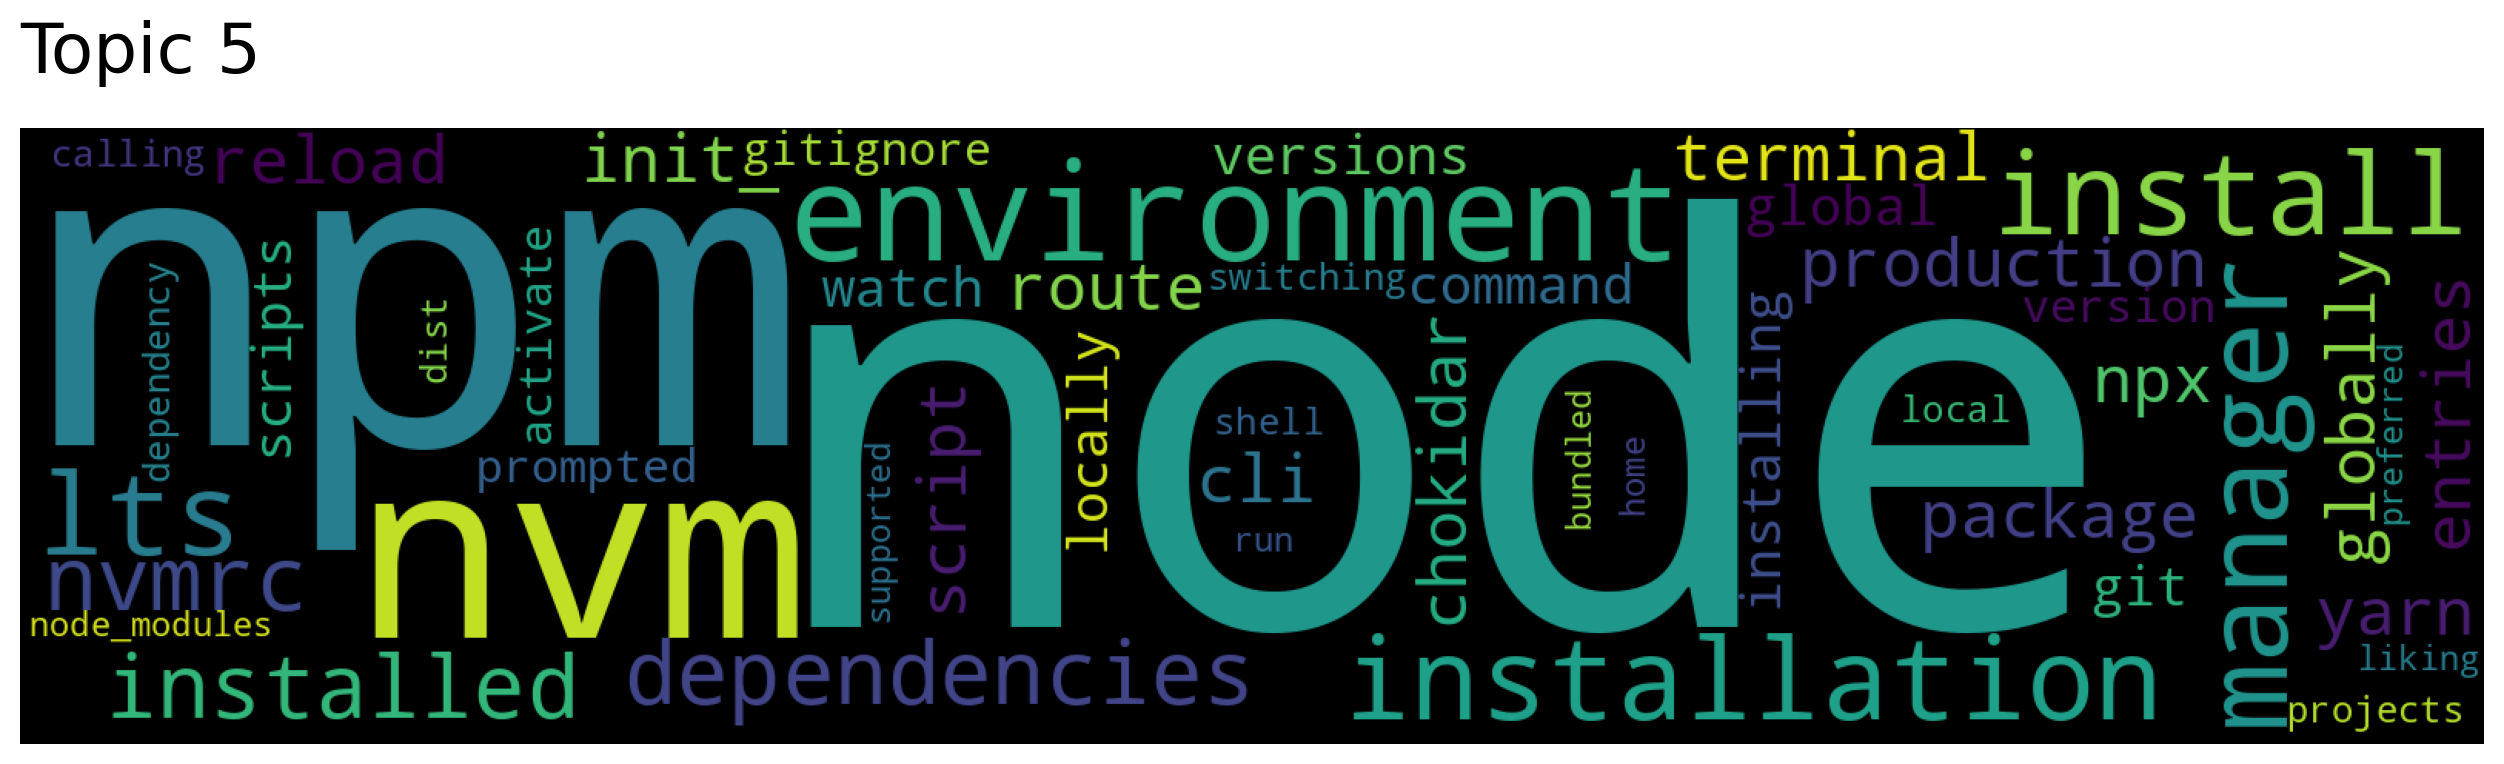

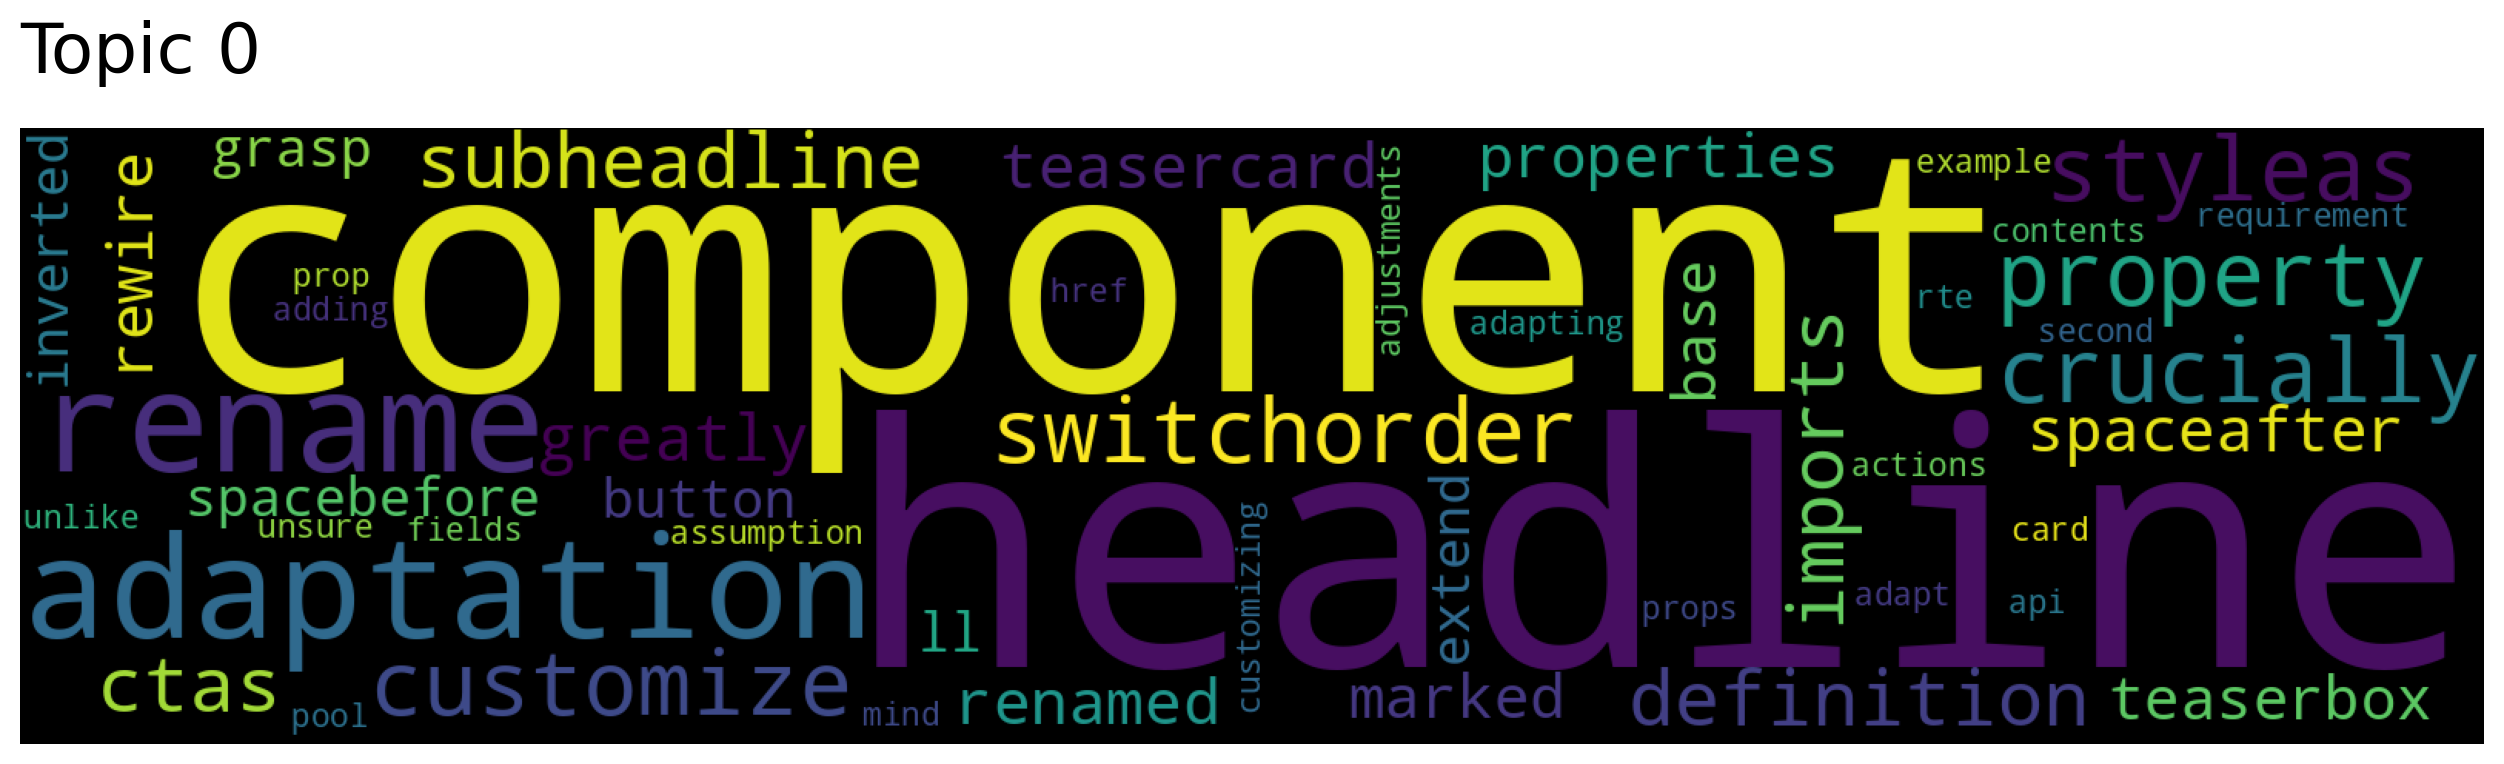

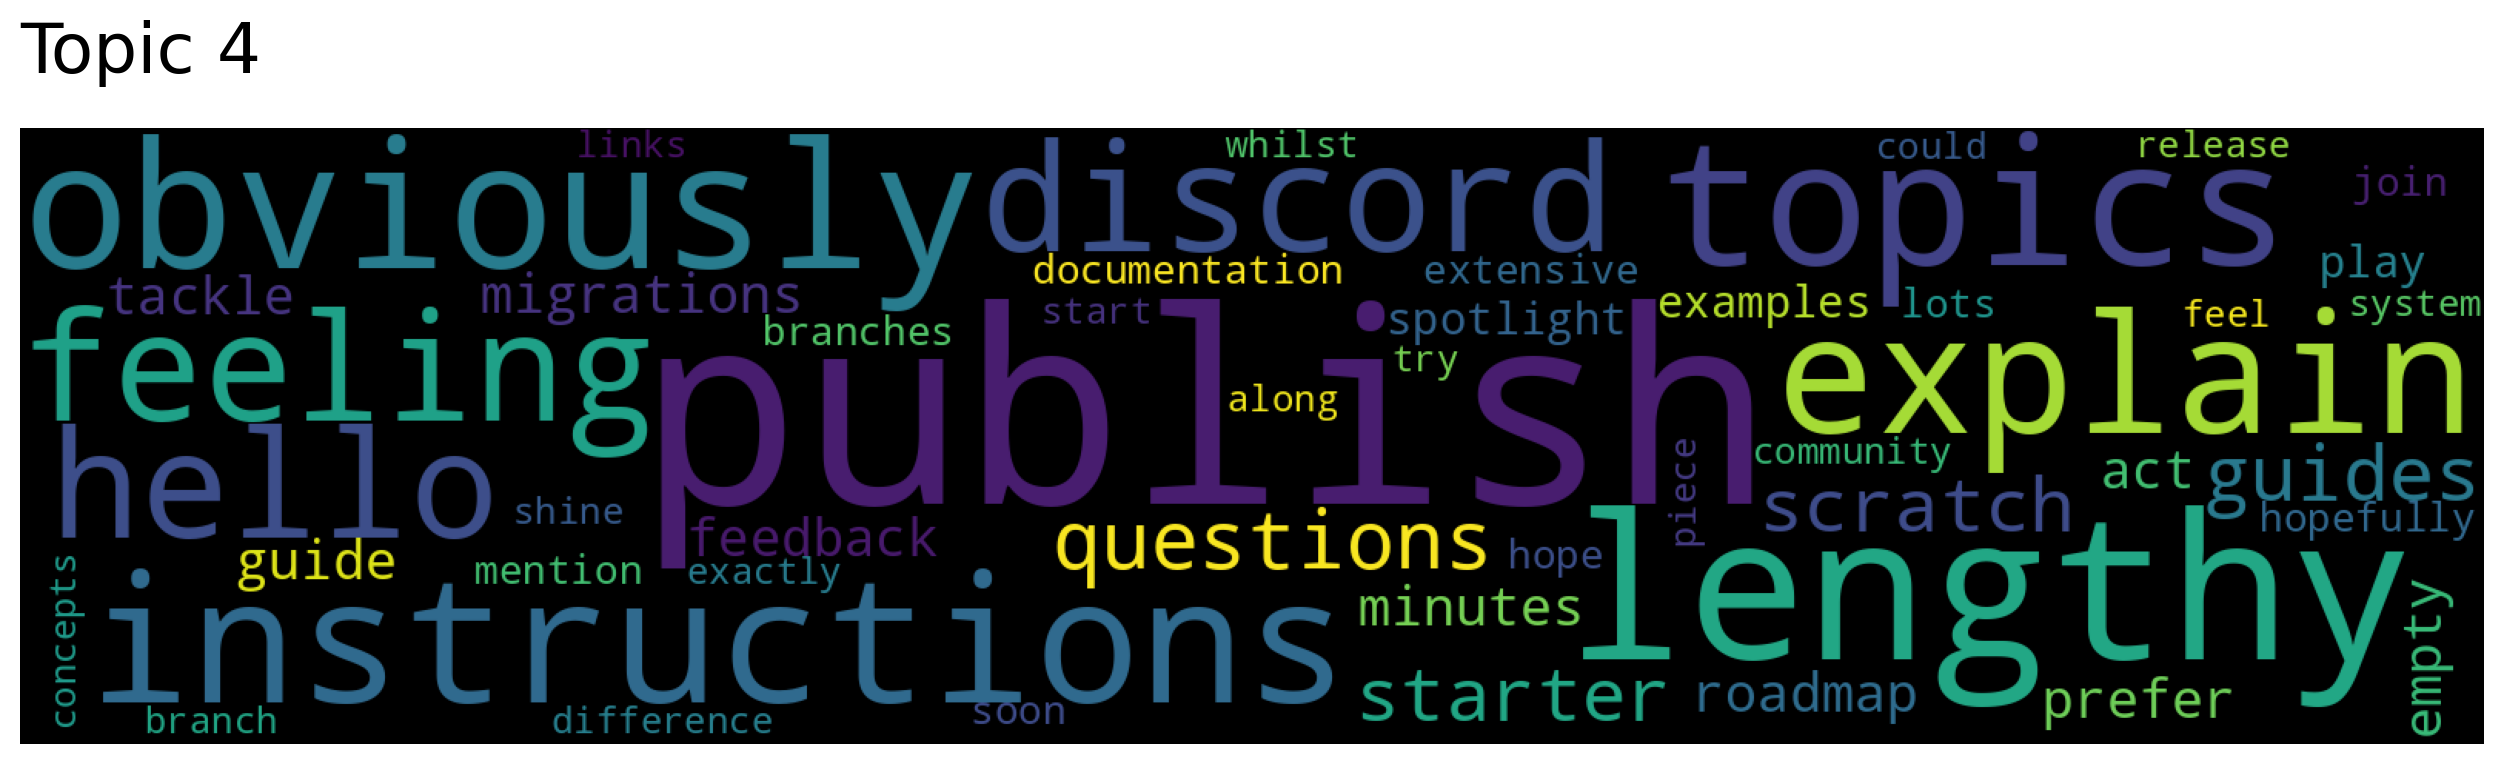

In [56]:
import jsonlines
from top2vec import Top2Vec

def getContents(page):
    return page['content']['raw']

documents = list()
with jsonlines.open('pages_extracted_sections.jsonl', 'r') as sections:
    for section in sections:
        documents.append(section['title'] + ' ' + section['heading'] + ' ' + section['content'])
        
print(str(len(documents)) + ' documents added for topic generation.')
model = Top2Vec(documents=documents, speed="deep-learn", workers=8, min_count=3)

print()
print(str(model.get_num_topics()) + ' topics discovered.')

print()
print('Top 3 topics returned for keyword search "kickstartDS":')
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["kickstartDS"], num_topics=3)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

print()
print('Top 10 words by similarity to keyword "kickstartDS":')
words, word_scores = model.similar_words(keywords=["kickstartDS"], keywords_neg=[], num_words=10)
for word, score in zip(words, word_scores):
    print(f"{word} {score}")

print()
print('Top 10 sections for topic #1')
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

In [ ]:
import json
from sentence_transformers import SentenceTransformer, CrossEncoder, util
import gzip
import os
import torch

if not torch.cuda.is_available():
    print("Warning: No GPU found. Please add GPU to your notebook")


#We use the Bi-Encoder to encode all passages, so that we can use it with sematic search
bi_encoder = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
bi_encoder.max_seq_length = 256     #Truncate long passages to 256 tokens
top_k = 32                          #Number of passages we want to retrieve with the bi-encoder

#The bi-encoder will retrieve 100 documents. We use a cross-encoder, to re-rank the results list to improve the quality
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

passages = []
with jsonlines.open('page_content.jsonl') as reader:
    for page in reader:
        #Add all paragraphs
        passages.extend(page['paragraphs'])

        #Only add the first paragraph
        #passages.append(page['paragraphs'][0])        

print("Passages:", len(passages))

# We encode all passages into our vector space. This takes about 5 minutes (depends on your GPU speed)
corpus_embeddings = bi_encoder.encode(passages, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
# We also compare the results to lexical search (keyword search). Here, we use 
# the BM25 algorithm which is implemented in the rank_bm25 package.

from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string
from tqdm.autonotebook import tqdm
import numpy as np

# We lower case our text and remove stop-words from indexing
def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc

tokenized_corpus = []
for passage in tqdm(passages):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
# This function will search all kickstartDS pages for passages that
# answer the query
def search(query):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -5)[-5:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)
    
    print("Top-5 lexical search (BM25) hits")
    for hit in bm25_hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    ##### Sematic Search #####
    # Encode the query using the bi-encoder and find potentially relevant passages
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=top_k)
    hits = hits[0]  # Get the hits for the first query

    ##### Re-Ranking #####
    # Now, score all retrieved passages with the cross_encoder
    cross_inp = [[query, passages[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # Sort results by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]

    # Output of top-5 hits from bi-encoder
    print("\n-------------------------\n")
    print("Top-5 Bi-Encoder Retrieval hits")
    hits = sorted(hits, key=lambda x: x['score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], passages[hit['corpus_id']].replace("\n", " ")))

    # Output of top-5 hits from re-ranker
    print("\n-------------------------\n")
    print("Top-5 Cross-Encoder Re-ranker hits")
    hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['cross-score'], passages[hit['corpus_id']].replace("\n", " ")))